# Car Detection with SVM

## Import States

In [1]:
import cv2, glob, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

%matplotlib inline

## Read Data

In [2]:
# read data_paths
car_paths = np.array(glob.glob('data/vehicles/**/*.png'))
noncar_paths = np.array(glob.glob('data/non-vehicles/**/*.png'))

NUM_CAR = car_paths.shape[0]
NUM_NONCAR = noncar_paths.shape[0]

print("car images:", NUM_CAR)
print("non_car images:", NUM_NONCAR)

car images: 8792
non_car images: 8968


## Show and Save Example Data

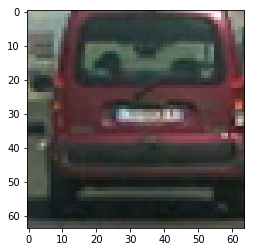

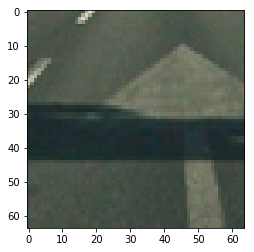

In [3]:
car_example = mpimg.imread(car_paths[1000])
plt.figure()
plt.imshow(car_example)
scipy.misc.imsave('output_images/car_ex.jpg', car_example)

noncar_example = mpimg.imread(noncar_paths[0])
plt.figure()
plt.imshow(noncar_example)
scipy.misc.imsave('output_images/noncar_ex.jpg', noncar_example)

## Shuffle Data

In [4]:
a = np.ones(NUM_CAR)
b = np.zeros(NUM_NONCAR)

paths = np.concatenate((car_paths, noncar_paths), axis=0)
labels = np.concatenate((a, b), axis=0)

paths, labels = shuffle(paths, labels)

## Divide Data to Training and Test set

In [5]:
ind = int(labels.shape[0] * 4 / 5)

train_paths = paths[:ind]
test_paths = paths[ind:]

train_labels = labels[:ind]
test_labels = labels[ind:]

print("train size:", train_labels.shape[0])
print("test size:", test_labels.shape[0])

train size: 14208
test size: 3552


## Data Augmentation function

In [6]:
def flip_img(img):
    return cv2.flip(img, 1)

In [7]:
def extend_labels(labels, mul):
    orig_size = labels.shape[0]
    res = np.zeros(orig_size * mul)
    for i in range(orig_size):
        for j in range(mul):
            res[i * mul + j] = labels[i]
    return res

## Feature Extraction functions

In [8]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return rhist, ghist, bhist, bin_centers, hist_features

In [9]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             

    features = cv2.resize(feature_image, size).ravel() 
    return features

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                transform_sqrt=False,
                                visualise=True,
                                feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, 
                        orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block), 
                        transform_sqrt=False, 
                        visualise=False, 
                        feature_vector=feature_vec)
        return features

In [11]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        images = []
        images.append(mpimg.imread(file))
        
        # data augmentation
        images.append(flip_img(images[0]))
        
        for image in images:
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
            
    # Return list of feature vectors
    return features

## Show Example Feature and Save

/home/anthony/.conda/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


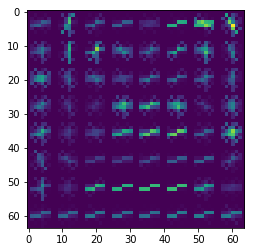

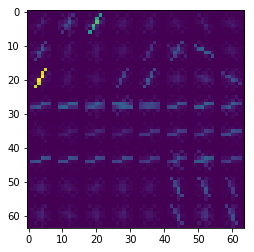

In [12]:
def extract_features_ex(img, orient=9, pix_per_cell=8, cell_per_block=2):
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    features, hog_img = get_hog_features(feature_image[:, :,0], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)
    return features, hog_img

_, hog_img = extract_features_ex(car_example)
plt.figure()
plt.imshow(hog_img)
scipy.misc.imsave('output_images/HOG_car_ex.jpg', hog_img)

_, hog_img = extract_features_ex(noncar_example)
plt.figure()
plt.imshow(hog_img)
scipy.misc.imsave('output_images/HOG_noncar_ex.jpg', hog_img)

## Extract Features

In [13]:
# Feature extraction parameters
colorspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t = time.time()
train_features = extract_features(train_paths,
                                  cspace=colorspace,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel)

test_features = extract_features(test_paths,
                                 cspace=colorspace,
                                 orient=orient,
                                 pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel)

t2 = time.time()
print('Extract times:', round(t2-t, 2), 'seconds.')

/home/anthony/.conda/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extract times: 153.7 seconds.


## Make Classifier with SVM

In [14]:
# data augmentation for labels
# image datas are augmented in extract_features function.
train_labels = extend_labels(train_labels, 2)
test_labels = extend_labels(test_labels, 2)

In [15]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(train_features, train_labels)
t2 = time.time()
print('Training times:', round(t2-t, 2), 'seconds.')
print('Test Accuracy of SVC = ', round(svc.score(test_features, test_labels), 4))

Training times: 13.96 seconds.
Test Accuracy of SVC =  0.9856


## Sliding Windows Search functions

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return rectangles

In [17]:
def find_cars_combined(img):    
    rect_list = []
    
    for i in range(8):
        rectangles = find_cars(img=img, ystart=400, ystop=656, scale=1.0 + i * 0.2, svc=svc,
                        X_scaler=None, orient=9, pix_per_cell=8, cell_per_block=2, 
                        spatial_size=(32, 32), hist_bins=32)
        rect_list.append(rectangles)
    
    rectangles = [item for sublist in rect_list for item in sublist] 
    return rectangles

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

## Test on Example Images

/home/anthony/.conda/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


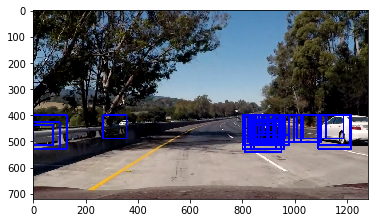

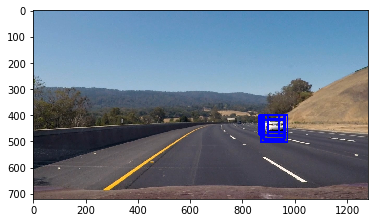

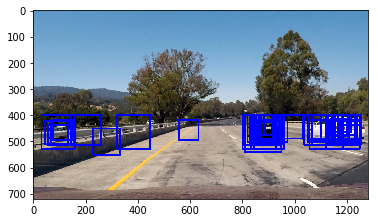

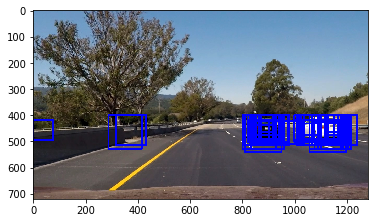

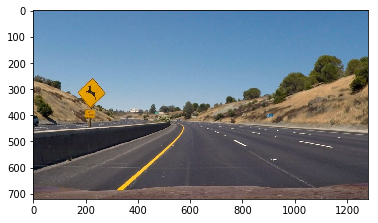

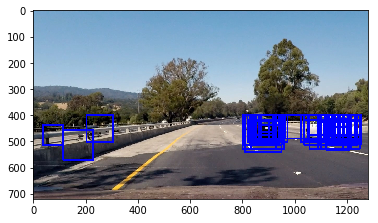

In [19]:
test_images_paths = glob.glob('test_images/*.jpg')
i = 0
for path in test_images_paths:
    img = mpimg.imread(path)
    draw_img = img.copy()
    rect_list = find_cars_combined(img)
    draw_img = draw_boxes(img, rect_list)

    scipy.misc.imsave('output_images/not_thresholded' + str(i) + '.jpg', draw_img)
    i += 1
    
    plt.figure()
    plt.imshow(draw_img)

## Multiple Detection and False Positives funtinons

In [20]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [21]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [22]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [23]:
def threshold_ops(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)    
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

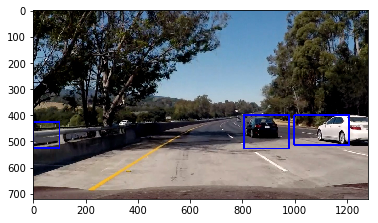

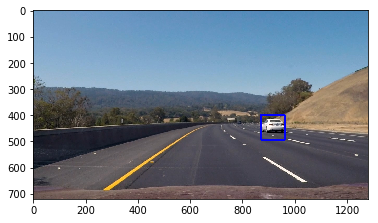

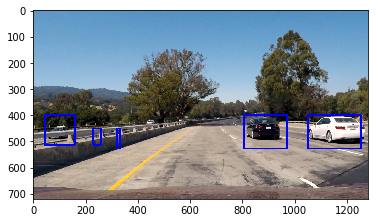

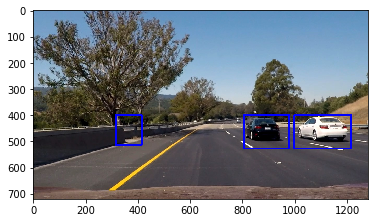

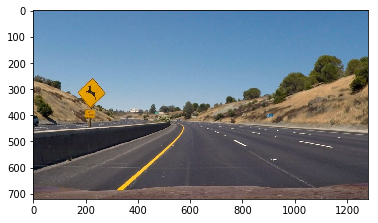

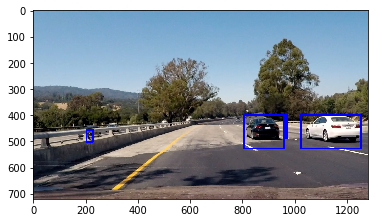

In [205]:
test_images_paths = glob.glob('test_images/*.jpg')
i = 0
for path in test_images_paths:
    img = mpimg.imread(path)
    rect_list = find_cars_combined(img)
    img_thresholded = threshold_ops(img, rect_list)
    
    scipy.misc.imsave('output_images/thresholded' + str(i) + '.jpg', img_thresholded)
    i += 1
    
    plt.figure()
    plt.imshow(img_thresholded)

## Test Pipeline on Video without Frame Operation

In [25]:
import imageio
imageio.plugins.ffmpeg.download()

In [26]:
def video_without_frame_ops(frame):
    rect_list = find_cars_combined(frame)
    img_thresholded = threshold_ops(frame, rect_list)
    return img_thresholded

In [27]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_video_out_without_frame.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(video_without_frame_ops)
%time clip_test_out.write_videofile(test_out_file, codec='libx264', audio=False)

[MoviePy] >>>> Building video test_video_out_without_frame.mp4
[MoviePy] Writing video test_video_out_without_frame.mp4


 97%|█████████▋| 38/39 [01:43<00:02,  2.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_without_frame.mp4 

CPU times: user 3min 47s, sys: 1.57 s, total: 3min 49s
Wall time: 1min 45s


In [28]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

## Frame Operation functions

In [196]:
def find_cars_combined_with_frame_ops(img, prev_rects):
    rect_list = []
    for i in range(8):
        rectangles = find_cars(img=img, ystart=400, ystop=656, scale=1.0 + i * 0.2, svc=svc,
                        X_scaler=None, orient=9, pix_per_cell=8, cell_per_block=2, 
                        spatial_size=(32, 32), hist_bins=32)
        rect_list.append(rectangles)
        
    rectangles = [item for sublist in rect_list for item in sublist] 
    
    # frame ops
    if len(prev_rects) > 7:
        prev_rects = prev_rects[len(prev_rects)-7:]
    prev_rects.append(rectangles)
    
    return rectangles

In [197]:
def threshold_ops_with_frame_ops(image, box_list, prev_rects):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    
    # frame ops
    for prev_rect in prev_rects:
        heat = add_heat(heat, prev_rect)
    heat = apply_threshold(heat, 4)
    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

## Test Pipeline on Video with Frame Operation

In [198]:
# initialize prev_rects
prevs = []

In [199]:
def video_with_frame_ops(frame):
    rect_list = find_cars_combined_with_frame_ops(frame, prevs)
    img_thresholded = threshold_ops_with_frame_ops(frame, rect_list, prevs)
    return img_thresholded

In [200]:
test_out_file = 'test_video_out_with_frame.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(video_with_frame_ops)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_with_frame.mp4
[MoviePy] Writing video test_video_out_with_frame.mp4



 97%|█████████▋| 38/39 [1:36:01<00:14, 14.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_with_frame.mp4 

CPU times: user 3min 45s, sys: 860 ms, total: 3min 46s
Wall time: 1h 36min 2s


In [201]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

## Apply Pipeline on Project Video

In [202]:
# initialize prev_rects
prevs.clear()

In [203]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(video_with_frame_ops)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 24%|██▍       | 303/1261 [13:52<43:22,  2.72s/it]


 48%|████▊     | 605/1261 [27:34<29:49,  2.73s/it]


 72%|███████▏  | 907/1261 [41:15<15:57,  2.70s/it]


 96%|█████████▌| 1205/1261 [54:49<02:31,  2.71s/it]


100%|█████████▉| 1260/1261 [57:18<00:02,  2.72s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2h 5min 9s, sys: 26.7 s, total: 2h 5min 36s
Wall time: 57min 20s


In [204]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))